In [1]:
from tqdm import tqdm
import pandas as pd
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import wandb
api = wandb.Api()

In [2]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    # "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [3]:
# Replace 'username/project_name' with your specific project path
# Composable_Interventions
project_paths = [
    'dri-ice/Composable_Interventions',
    # 'dri-ice/AK_Tests'
]

filter_dict = { 
    "state": "finished",
    # "created_at": {"$gte": "2024-05-20"}
}
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)
    
    # Iterate over eachrun and capture the config and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-05-23 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True
            
            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")

# Sort by 'tag' and '_timestamp' in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=['tag', '_timestamp'], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit='s')
all_runs_df_sorted = all_runs_df.sort_values(by=['_timestamp'], ascending=[False])

dri-ice/Composable_Interventions: 100%|██████████| 305/305 [00:02<00:00, 150.16it/s]

Error processing run n0iel6ok: '_timestamp'
Error processing run xr5mede5: '_timestamp'
Error processing run 27f8pxs0: '_timestamp'


In [4]:
# TODO: Ensure that max number of questions is set to None 
# TODO: Ensure that rmu_layer_id is 3. This was originaly set to 5, but Kyle decided to rerun the evals last minute with a better hyperparameter.

In [5]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset="tag", keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "Lora",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
}
metrics = all_runs_df_deduplicated
metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
metrics["edit"] = metrics["edit"].apply(lambda x : rename_dict.get(x, None))
metrics["compression"] = metrics["compression"].apply(lambda x : rename_dict.get(x, None))
metrics["unlearn"] = metrics["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = metrics
all_runs_df_deduplicated.value_counts("tag")

/tmp/ipykernel_143838/787060927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))
/tmp/ipykernel_143838/787060927.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["model_name"] = metrics["model_name"].apply(lambda x : rename_dict.get(x, None))
/tmp/ipykernel_143838/787060927.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

tag
AWQ2bit-to-ft              1
lora-to-SparseGPT0.35%     1
lora-to-AWQ4bit            1
lora-to-AWQ5bit            1
lora-to-AWQ6bit            1
                          ..
SparseGPT0.55%-to-memit    1
SparseGPT0.65%-to-ft       1
SparseGPT0.65%-to-lora     1
SparseGPT0.65%-to-memit    1
wanda0.65\%-rmu            1
Name: count, Length: 187, dtype: int64

In [6]:
# TODO: Get a second pair of eyes on this this math

# Math for determining number of interventions
awq_settings = 5
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

66
48


In [7]:
data = all_runs_df_deduplicated

categories = {
    "No Intervention": data[data["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": data[data["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": data[data["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": data[data["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": data[data["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": data[data["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": data[data["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": data[data["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": data[data["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": data[data["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
# assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

# display(categories["Compression to Edit"])
# Missing Wanda0.25%-to-lora, Wanda0.45%-to-lora, Wanda0.65%-to-lora, 
# assert len(categories["Compression to Edit"]) == (editor_count // 2 )- 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 1, f"{len(categories['Unlearn'])} != 1"
assert len(categories["Edit to Unlearn"]) == 3
assert len(categories["Unlearn to Edit"]) == 3, f"{len(categories['Unlearn to Edit'])} != 3"

# display(categories["Compress to Unlearn"])
# assert len(categories["Compress to Unlearn"]) == rmu_count // 2, f"{len(categories['Compress to Unlearn'])} != {rmu_count // 2}"

# display(categories["Unlearn to Compress"])
# assert len(categories["Unlearn to Compress"]) == rmu_count // 2, f"{len(categories['Unlearn to Compress'])} != {rmu_count // 2}"


In [8]:
def format_flops(value):
    """ Format FLOPs with three significant figures and appropriate suffix. """
    try:
        if isinstance(value, str):
            value = clean_numeric_value(value)
        if abs(value) < 1e6:  # Less than 1 million (below Mega)
            return "{:.3g}k".format(value / 1e3)
        elif abs(value) < 1e9:  # Mega to Giga range
            return "{:.3g}M".format(value / 1e6)
        elif abs(value) < 1e12:  # Giga to Tera range
            return "{:.3g}G".format(value / 1e9)
        else:  # Tera and above
            return "{:.3g}T".format(value / 1e12)
    except Exception as e:
        print(f"Error formatting FLOPs value {value}: {e}")
        return "---"

def escape_latex_special_chars(s):
    """ Escape special characters in LaTeX strings. """
    return str(s).replace('%', '\\%').replace('_', '\\_').replace('&', '\\&').replace('#', '\\#').replace('$', '\\$')

def clean_numeric_value(value):
    """ Convert a string with units to a numeric value. """
    try:
        value = str(value)
        if ' TFLOPS' in value:
            return float(value.replace(' TFLOPS', '')) * 1e12
        if ' GFLOPS' in value:
            return float(value.replace(' GFLOPS', '')) * 1e9
        if ' MFLOPS' in value:
            return float(value.replace(' MFLOPS', '')) * 1e6
        if ' kFLOPS' in value:
            return float(value.replace(' kFLOPS', '')) * 1e3
        return pd.to_numeric(value, errors='coerce')
    except Exception as e:
        print(f"Error cleaning value {value}: {e}")
        return pd.NA

def categorize_and_generate_latex(data):
    # Define categories based on the provided criteria
    categories = {
    "No Intervention": data[data['interventions'].apply(lambda x: x == [])].copy(),
    "Editing": data[data['interventions'].apply(lambda x: x == ['edit'])].copy(),
    "Compression": data[data['interventions'].apply(lambda x: x == ['compress'])].copy(),
    "Edit to Compression": data[data['interventions'].apply(lambda x: x == ['edit', 'compress'])].copy(),
    "Compression to Edit": data[data['interventions'].apply(lambda x: x == ['compress', 'edit'])].copy(),
    "Unlearn": data[data['interventions'].apply(lambda x: x == ['unlearn'])].copy(),
    "Edit to Unlearn": data[data['interventions'].apply(lambda x: x == ['edit', 'unlearn'])].copy(),
    "Unlearn to Edit": data[data['interventions'].apply(lambda x: x == ['unlearn', 'edit'])].copy(),
    "Compress to Unlearn": data[data['interventions'].apply(lambda x: x == ['compress', 'unlearn'])].copy(),
    "Unlearn to Compress": data[data['interventions'].apply(lambda x: x == ['unlearn', 'compress'])].copy()
}
    # Clean numeric columns
    for col in ["FLOPs", "Latency"]:
        if col in data.columns:
            data.loc[:, col] = data[col].apply(clean_numeric_value)
            data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')  # Ensure all values are numeric

    # Column mappings
    column_mappings = {
        "Success": "Rewrite accuracy",
        "Generalization": "Generalization",
        "Locality": "Locality",
        "Avg. Bits": "Average bits",
        "FLOPs": "FLOPs",
        "PPL": "PPL",
        "MMLU": "mmlu accuracy",
        "WMDP Bio": "wmdp_bio accuracy",
        "WMDP Cyber": "wmdp_cyber accuracy"
    }
    latex_columns = ["Success", "Generalization", "Locality", "Avg. Bits", "FLOPs", "PPL", "MMLU", "WMDP Bio", "WMDP Cyber"]

    # Initialize output string
    output_str = ""

    for category, group in categories.items():
        if group.empty:
            continue
        # output_str += f"\\textbf{{{category}}} \\\\ \\midline\n"
        for _, row in group.iterrows():
            # Calculate mean and std for each relevant column within the group
            stats = {}
            for latex_col, csv_col in column_mappings.items():
                if csv_col in row.index:
                    value = row[csv_col]
                    if pd.isna(value):
                        stats[latex_col] = "---"
                    else:
                        # Custom formatting for FLOPs and Latency
                        if latex_col == "FLOPs":
                            mean_str = format_flops(value)
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        elif latex_col == "Latency":
                            mean_str = f"{value:.3f}s"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                        else:
                            mean_str = f"{value:.3f}"
                            stats[latex_col] = escape_latex_special_chars(mean_str)
                else:
                    stats[latex_col] = "---"

            # Prepare the LaTeX row for the current group
            latex_row = escape_latex_special_chars(row['tag'])  # Use the tag name directly without escaping
            for column in latex_columns:
                latex_row += " & " + stats.get(column, "---")
            latex_row += " \\\\"

            # Append to output string
            output_str += latex_row + "\n"
        
        output_str += "\\midrule\n"

    return output_str

latex_rows_with_categories = categorize_and_generate_latex(all_runs_df_deduplicated)
print(latex_rows_with_categories)

None & 0.009 & 0.021 & 0.027 & 16.000 & 1.92T & 5.540 & 0.621 & 0.714 & 0.442 \\
\midrule
lora\_Edit & 1.000 & 0.647 & 0.030 & 16.000 & 1.79T & 21.656 & 0.607 & 0.700 & 0.444 \\
memit\_Edit & 0.990 & 0.887 & 0.050 & 16.000 & 1.92T & 5.570 & 0.602 & 0.687 & 0.435 \\
ft\_Edit & 1.000 & 0.769 & 0.117 & 16.000 & 1.92T & 5.570 & 0.611 & 0.690 & 0.438 \\
\midrule
Compress\_GPTQ8bit & 0.009 & 0.021 & 0.024 & 8.250 & -0.001k & 5.539 & 0.622 & 0.713 & 0.439 \\
Compress\_GPTQ4bit & 0.000 & 0.009 & 0.018 & 4.250 & -0.001k & 14.088 & 0.600 & 0.682 & 0.441 \\
Compress\_GPTQ2bit & 0.000 & 0.000 & 0.023 & 2.250 & -0.001k & 2089.334 & 0.237 & 0.254 & 0.255 \\
Compress\_AWQ4bit & 0.000 & 0.011 & 0.027 & 4.250 & -0.001k & 5.911 & 0.598 & 0.687 & 0.456 \\
Compress\_AWQ8bit & 0.009 & 0.021 & 0.027 & 8.250 & -0.001k & 5.540 & 0.621 & 0.713 & 0.444 \\
Compress\_AWQ2bit & 0.000 & 0.000 & 0.000 & 2.250 & -0.001k & 1748954.750 & 0.269 & 0.240 & 0.246 \\
Compress\_SparseGPT0.65\% & 0.009 & 0.004 & 0.018 & 6.250

NameError: name 'included_models' is not defined

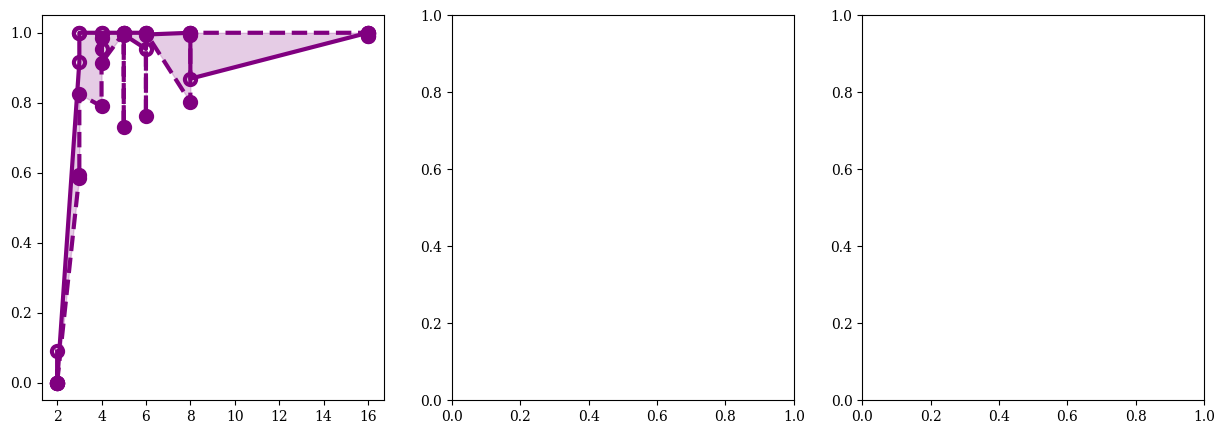

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the font family to serif
plt.rcParams['font.family'] = 'serif'

# Assuming 'metrics' DataFrame is already loaded from the CSV

# Define the criteria for filtering
selected_method = 'AWQ'
edit_method = ["FT"]

# Filter based on the criteria
edit_then_compress = categories['Edit to Compression']
compress_then_edit = categories['Compression to Edit']

# Filter based on selected method
edit_then_compress = edit_then_compress[edit_then_compress['compression']==selected_method]
compress_then_edit = compress_then_edit[compress_then_edit['compression']==selected_method]

# Add baselines to dfs
baseline = categories['Editing']
baseline['wbits'] = 16
edit_then_compress = pd.concat([edit_then_compress, baseline], axis=0)
compress_then_edit = pd.concat([compress_then_edit, baseline], axis=0)

# Sort by 'wbits' in ascending order
edit_then_compress = edit_then_compress.sort_values(by='wbits')
compress_then_edit = compress_then_edit.sort_values(by='wbits')

# Define the metrics to plot
metrics_to_plot = ['Rewrite accuracy', 'Generalization', 'mmlu']
x_axis_metric = 'wbits'

# Compute baselines
# edit_then_compress_baselines = {model: edit_then_compress[(edit_then_compress['model_name'] == model) & (edit_then_compress['sparsity_ratio'] == 0)][metrics_to_plot].mean() for model in included_models}
# compress_then_edit_baselines = {model: compress_then_edit[(compress_then_edit['model_name'] == model) & (compress_then_edit['sparsity_ratio'] == 0)][metrics_to_plot].mean() for model in included_models}
# edit_then_compress_baselines = categories['No Intervention']
# compress_then_edit_baselines = categories['No Intervention']

# Define plot parameters
title_fontsize = 20
label_fontsize = 20
legend_fontsize = 18
tick_fontsize = 18
line_width = 3
marker_size = 8

# Create subplots
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(15, 5))

# Iterate over each metric and plot
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    # Plot the data with scatter and lines
    ax.plot(edit_then_compress['wbits'], edit_then_compress[metric], linestyle='--', marker='o', markerfacecolor='purple', color='purple', label='Edit then compress',
            linewidth=line_width, markersize=marker_size, markeredgewidth=line_width)
    ax.plot(compress_then_edit['wbits'], compress_then_edit[metric], linestyle='-', marker='o', markerfacecolor='none', color='purple', label='Compress then edit',
            linewidth=line_width, markersize=marker_size, markeredgewidth=line_width)
    
    # Fill the area between the lines
    ax.fill_between(edit_then_compress['wbits'], edit_then_compress[metric], compress_then_edit[metric], color='purple', alpha=0.2)
    
    # Integrate baselines into the scatter plots
    for model in included_models:
        baseline_edit = edit_then_compress_baselines[metric]
        baseline_compress = compress_then_edit_baselines[metric]
        
        if x_axis_metric == 'Average bits':
            baseline_x = 16
            ax.set_xlim(2, 16)
        elif x_axis_metric == 'sparsity_ratio':
            baseline_x = 0.0
            ax.set_xlim(0, 1)
        else:
            baseline_x = 0  # Adjust based on your default x-axis range

        # Add baselines to the scatter plots
        # ax.scatter([baseline_x], [baseline_edit], color='purple', marker='o', s=marker_size**2, edgecolor='purple', linewidth=line_width)
        # ax.scatter([baseline_x], [baseline_compress], color='purple', marker='o', s=marker_size**2, edgecolor='purple', linewidth=line_width)
    if x_axis_metric == 'wbits':
        ax.set_xlabel('Bits', fontsize=label_fontsize)
    else:
        ax.set_xlabel(x_axis_metric, fontsize=label_fontsize)
    if metric == 'Rewrite accuracy':
        ax.set_ylabel('Edit success', fontsize=label_fontsize)
    else:
        ax.set_ylabel(metric, fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Move the legend to the bottom of the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=legend_fontsize, ncol=2)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust the bottom margin to make space for the legend
plt.show()
plt.savefig('figures/memit-gptq.pdf', format='pdf')
